## OOI Lab Manual 2025: Lab 7 Water Masses: Activity 1 Thermohaline Circulation

This notebook demonstrates how to access and process the dataset used in *Lab 7 Water Masses* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 17, 2025

In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

For this activity we will use temperature and density data from several CTDs at Irminger Sea Flanking Mooring B

* 30m - ooi-gi03flmb-rim01-02-ctdmog060
* 90m - ooi-gi03flmb-rim01-02-ctdmog063
* 350m - ooi-gi03flmb-rim01-02-ctdmog067
* 1000m - ooi-gi03flmb-rim01-02-ctdmoh070


In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

In [3]:
ctds = {
  '30m': 'ooi-gi03flmb-rim01-02-ctdmog060',
  '90m': 'ooi-gi03flmb-rim01-02-ctdmog063',
  '350m': 'ooi-gi03flmb-rim01-02-ctdmog067',
  '1000m': 'ooi-gi03flmb-rim01-02-ctdmoh070'
  }
ctd_depths = list(ctds.keys())

In [4]:
# Load the data for each CTD
dfs = []
for depth, dataset_id in ctds.items():
  url_ctd = e.get_download_url(
    dataset_id=dataset_id,
    variables=['time', 'sea_water_temperature', 'sea_water_practical_salinity', 'sea_water_pressure', 'sea_water_density'],
    constraints={"time>=": "2015-01-01", "time<=": "2023-01-01"}
  )
  df_ctd = pd.read_csv(url_ctd, index_col='time', parse_dates=True, skiprows=[1])

  dfs.append(df_ctd)
  print(f"Data for {depth} depth loaded.")

Data for 30m depth loaded.
Data for 90m depth loaded.
Data for 350m depth loaded.
Data for 1000m depth loaded.


### Filter and Plot
Now that we have the data loaded, let's filter out some errant data points.  Then we'll plot all the raw data.

In [5]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 5
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]
    return ind

In [6]:
# Filter out outliers
for df_ctd in dfs:
    df_ctd['sea_water_practical_salinity'] = df_ctd['sea_water_practical_salinity'].where(reject_outliers(df_ctd['sea_water_practical_salinity']))
    df_ctd['sea_water_pressure'] = df_ctd['sea_water_pressure'].where(reject_outliers(df_ctd['sea_water_pressure']))
    df_ctd['sea_water_density'] = df_ctd['sea_water_density'].where(reject_outliers(df_ctd['sea_water_density']))


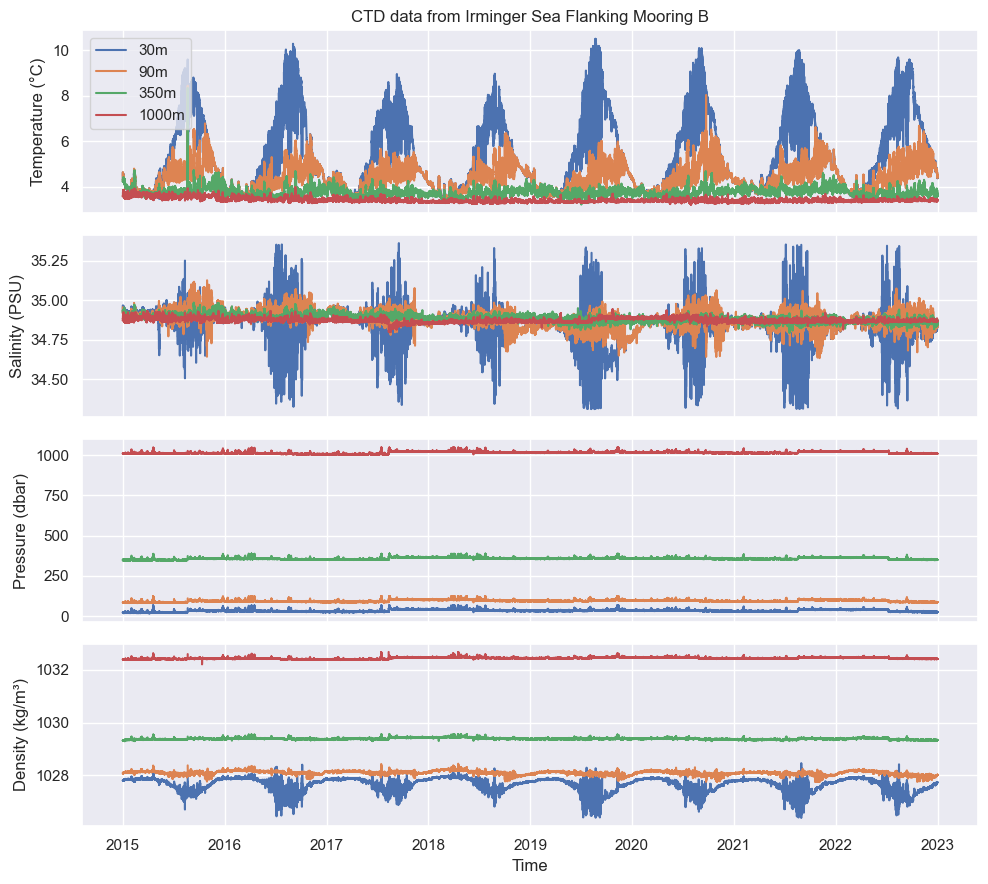

In [7]:
# Plot the raw data
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

for i,df in enumerate(dfs):
    axs[0].plot(df.index, df['sea_water_temperature'], label=ctd_depths[i])
    axs[1].plot(df.index, df['sea_water_practical_salinity'], label=ctd_depths[i])
    axs[2].plot(df.index, df['sea_water_pressure'], label=ctd_depths[i])
    axs[3].plot(df.index, df['sea_water_density'], label=ctd_depths[i])

axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='best')
axs[0].set_title('CTD data from Irminger Sea Flanking Mooring B')

axs[1].set_ylabel('Salinity (PSU)')
axs[2].set_ylabel('Pressure (dbar)')
axs[3].set_ylabel('Density (kg/m³)')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

### Calculate Potential Density
Next we need to convert to potential density. 

This removes the compressibility effect on density so that we can compare the densities at different depths (pressures).

In [8]:
import gsw

for df_ctd in dfs:
    # Calculate Absolute Salinity
    SA = gsw.SA_from_SP(df_ctd['sea_water_practical_salinity'], df_ctd['sea_water_pressure'], -39.31, 59.72)
    
    # Calculate Conservative Temperature
    CT = gsw.CT_from_t(SA, df_ctd['sea_water_temperature'], df_ctd['sea_water_pressure'])
    
    # Calculate potential density anomaly with reference pressure of 0 dbar
    df_ctd['potential_density'] = gsw.density.sigma0(SA, CT)

    print(f"Potential density calculated for dataset.")

Potential density calculated for dataset.
Potential density calculated for dataset.
Potential density calculated for dataset.
Potential density calculated for dataset.


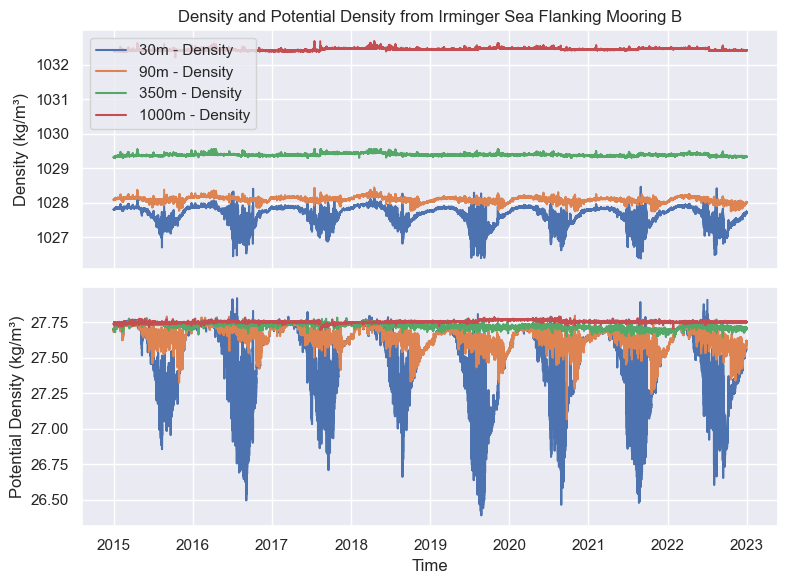

In [9]:
# Plot the 2 kinds of density 
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for i, df in enumerate(dfs):
    axs[0].plot(df.index, df['sea_water_density'], label=f'{ctd_depths[i]} - Density')
    axs[1].plot(df.index, df['potential_density'], label=f'{ctd_depths[i]} - Potential Density')
axs[0].set_ylabel('Density (kg/m³)')
axs[1].set_ylabel('Potential Density (kg/m³)')
axs[0].legend(loc='best')

axs[0].set_title('Density and Potential Density from Irminger Sea Flanking Mooring B')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

### Average

Next let's take a weekly running mean so that the data is slightly filtered.
We'll also subset the dataset for simplicity.

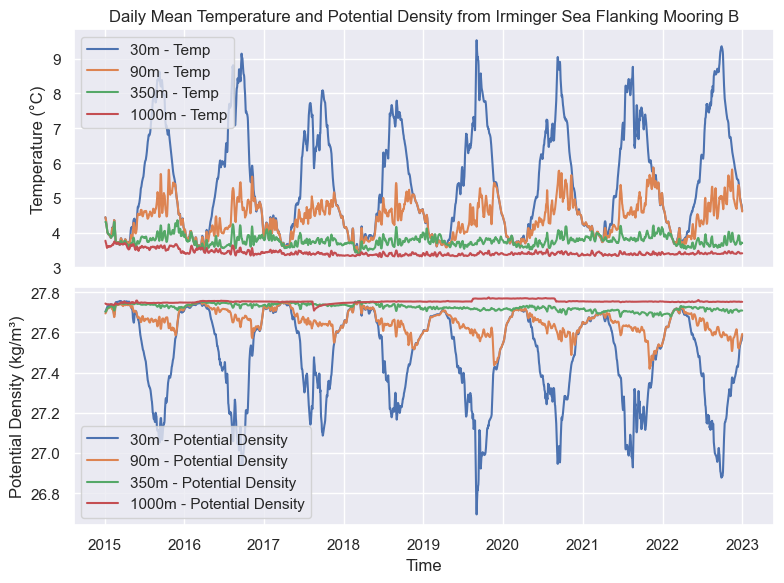

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for i, df_ctd in enumerate(dfs):
    df_weekly_mean = df_ctd.resample('1D').mean().rolling('7D', min_periods=5).mean() 
    # df_weekly_mean = df_ctd.resample('1D').mean().resample('1W').mean()

    # Plot temperature and potential density
    axs[0].plot(df_weekly_mean.index, df_weekly_mean['sea_water_temperature'], label=f'{ctd_depths[i]} - Temp')
    axs[1].plot(df_weekly_mean.index, df_weekly_mean['potential_density'], label=f'{ctd_depths[i]} - Potential Density')

axs[0].set_ylabel('Temperature (°C)')
axs[1].set_ylabel('Potential Density (kg/m³)')
axs[0].legend(loc='best')
axs[1].legend(loc='best')

axs[0].set_title('Daily Mean Temperature and Potential Density from Irminger Sea Flanking Mooring B')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [ ]:
# Initialize an empty list to store the weekly mean dataframes
weekly_means = []

# Loop over all CTDs
for i, df_ctd in enumerate(dfs):
    # Calculate weekly mean from a daily mean
    df_weekly_mean = df_ctd.resample('1D').mean().rolling('7D', min_periods=5).mean() 
    # df_weekly_mean = df_ctd.resample('1D').mean().resample('1W').mean()
    
    # Rename variables with the depth suffix
    depth_suffix = ctd_depths[i]
    df_weekly_mean = df_weekly_mean.rename(columns={
        'sea_water_temperature': f'{depth_suffix} Temp',
        'sea_water_practical_salinity': f'{depth_suffix} Salinity',
        'sea_water_pressure': f'{depth_suffix} Pressure',
        'sea_water_density': f'{depth_suffix} Density',
        'potential_density': f'{depth_suffix} Potential Density'
    })
    
    # Append the weekly mean dataframe to the list
    weekly_means.append(df_weekly_mean)



In [16]:
# Merge all weekly mean dataframes into a single dataframe
df_merged = pd.concat(weekly_means, axis=1)

# Reorder the columns in depth order by variable
ordered_columns = []
variables = ['Temp', 'Density', 'Potential Density']
for var in variables:
    for depth in ctd_depths:
        ordered_columns.append(f'{depth} {var}')

df_merged = df_merged[ordered_columns]

# Display the merged dataframe
df_merged.head()

,30m Temp,90m Temp,350m Temp,1000m Temp,30m Density,90m Density,350m Density,1000m Density,30m Potential Density,90m Potential Density,350m Potential Density,1000m Potential Density
time,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,4.442491,4.440046,4.309671,3.768587,1027.80961,1028.089268,1029.317166,1032.400269,27.704031,27.694106,27.70276,27.74355


In [17]:
# Trim the date to just the date part
df_merged.index = df_merged.index.date
df_merged.index.name = 'date'

# Simplify the values to 3 decimals
df_merged = df_merged.round(3)

# Save to CSV
df_merged.to_csv('data/lab7_thermohaline_weekly.csv')